In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
df0 = pd.read_csv('data/annual_csi_data_for_match.csv', sep=',')

In [3]:
df0.rename(index=str, columns={"datatime": "datetime"}, inplace=True)
df0['datetime'] = pd.to_datetime(df0['datetime'])
df0.reset_index(drop = True, inplace = True)

In [4]:
df0.head()

,datetime,lat,lon,city,actualkwh,irradiancekwh,pr,mount_type,koeppen,capacity_dc_kw,tilt,azimuth,paneltype,cellcategory,cod,invertermake,invertermodel,panelmake,panelmodel
0,2009-01-01,36.817933,-119.759976,Fresno,215457.0875,278138.156430,0.774641,Fixed - Roof Mounted,Moderate,161.120,30.0,180.0,mono,Premium,2008-09-05,SatCon,AE-135-60-PV-A,SunPower,PL-EVER-ES-190P
1,2010-01-01,36.817933,-119.759976,Fresno,193487.6600,261959.131597,0.738618,Fixed - Roof Mounted,Moderate,161.120,30.0,180.0,mono,Premium,2008-09-05,SatCon,AE-135-60-PV-A,SunPower,PL-EVER-ES-190P
2,2009-01-01,34.016505,-118.113753,Montebello,288246.6500,416118.658276,0.692703,Fixed - Roof Mounted,Moderate,243.200,30.0,180.0,mono,Premium,2007-08-01,Xantrex,PV225S-480-P,SunPower,PL-EVER-ES-190P
3,2010-01-01,34.016505,-118.113753,Montebello,252797.2250,409327.120794,0.617592,Fixed - Roof Mounted,Moderate,243.200,30.0,180.0,mono,Premium,2007-08-01,Xantrex,PV225S-480-P,SunPower,PL-EVER-ES-190P
4,2009-01-01,33.782519,-117.228648,Perris,56125.0000,81674.965560,0.687175,Fixed - Roof Mounted,Moderate,46.592,30.0,180.0,poly,Standard,2007-10-15,SatCon,AE-50-60-PV-D,Sharp,ND-208U2


In [107]:
df0.shape

(8157, 19)

In [112]:
df0.panelmake.value_counts()

SunPower               1233
Sharp                  1080
BP                      700
Suntech                 572
Kyocera                 566
Yingli                  517
SolarWorld              468
Evergreen               359
Sanyo                   345
Trina                   327
Canadian                286
Mitsubishi              210
REC                     157
Siliken                 128
Schuco                  122
Schott                  117
Andalay                  82
First Solar              77
ET                       75
Mixed                    69
Phono                    55
Hanwha                   55
DelSolar                 42
Conergy                  35
Hyundai                  33
Astronergy               30
Chaori                   30
SPI                      28
Solyndra                 23
United                   21
                       ... 
Supreme                   4
Silray                    4
Atlantis                  4
Zhejiang                  4
Jiangsu Green Power 

In [5]:
# Function to inspect all value counts at once excluding 'lat' & 'lon'
def val_counts(df):
    for i in df.columns:
        if i not in ['lat', 'lon']:
            print(df[f'{i}'].value_counts())

In [6]:
def dt_to_year(df):
    df['year'] = np.zeros(df.shape[0])
    for i, el in df['datetime'].iteritems():
        df.at[i,'year'] = el.year
    df['year'] = df['year'].astype(int)
    df.drop(['datetime'], axis=1, inplace=True)

In [111]:
# def pop_year(yr):
#     mask = df['year']==yr
#     df_new = df[mask]
#     return df_new

In [7]:
def clean_data(df):    
    drop_list = ['city', 'cod', 'panelmodel','invertermodel','lon','pr','invertermake','panelmake']
    df.drop(drop_list, axis=1, inplace=True)
    df.paneltype.fillna(value = 'poly', inplace=True)
    df.mount_type.fillna(value = 'Fixed - Roof Mounted', inplace=True)
    df['cellcategory'].replace('Unknown', 'Standard', inplace=True)
    df['azimuth'].replace('Mixed', 180, inplace=True)
    df['azimuth'] = df['azimuth'].astype(float)
    # df['tilt_mixed'] = (df['tilt']=='Mixed')*1
    df['tilt'].replace('Mixed', round(df['lat'],1),inplace=True)
    df['tilt'] = df['tilt'].astype(float)
    df['lat'] = round(df['lat'],1)
    
    for i, el in df['paneltype'].iteritems():
        if el not in ['poly','mono']:
            df.at[i,'paneltype']='other'
    return df

In [8]:
df = df0.copy()

In [9]:
dt_to_year(df)

In [10]:
df.shape

(8157, 19)

In [11]:
df.reset_index(drop = True, inplace = True)
df['lat'] = round(df['lat'],2)
df['lon'] = round(df['lon'],2)

In [16]:
df.to_csv('data/readyforweath.csv',index=False)

# Make DF of lat/lon/yr for NASA API

In [15]:
cols_lly = ['lat','lon','year']
df_lly = df.reindex(cols_lly,axis=1)

In [16]:
df_lly.shape

(8157, 3)

In [79]:
df_lly_test = df_lly.iloc[:100,:]
df_lly_test

,lat,lon,year
0,36.82,-119.76,2009
1,36.82,-119.76,2010
2,34.02,-118.11,2009
3,34.02,-118.11,2010
4,33.78,-117.23,2009
5,33.78,-117.23,2010
6,38.03,-122.03,2009
7,38.03,-122.03,2010
8,34.03,-117.58,2009
9,33.63,-117.87,2009


In [80]:
df_lly_test.to_csv('data/lly_test.csv',index=False)

In [17]:
df_lly.to_csv('data/lly.csv',index=False)

In [20]:
df_lly2 = df_lly.copy()

In [21]:
df_lly2.drop_duplicates(inplace=True)

In [24]:
df_lly2.to_csv('data/lly_unique.csv',index=False)

## Run clean data function

In [13]:
df = clean_data(df)

In [14]:
# Check df
df.head().T

,0,1,2,3,4
lat,36.8,36.8,34,34,33.8
actualkwh,215457,193488,288247,252797,56125
irradiancekwh,278138,261959,416119,409327,81675
mount_type,Fixed - Roof Mounted,Fixed - Roof Mounted,Fixed - Roof Mounted,Fixed - Roof Mounted,Fixed - Roof Mounted
koeppen,Moderate,Moderate,Moderate,Moderate,Moderate
capacity_dc_kw,161.12,161.12,243.2,243.2,46.592
tilt,30,30,30,30,30
azimuth,180,180,180,180,180
paneltype,mono,mono,mono,mono,poly
cellcategory,Premium,Premium,Premium,Premium,Standard


In [12]:
# Check df
df.head().T

,0,1,2,3,4
lat,36.82,36.82,34.02,34.02,33.78
lon,-119.76,-119.76,-118.11,-118.11,-117.23
city,Fresno,Fresno,Montebello,Montebello,Perris
actualkwh,215457,193488,288247,252797,56125
irradiancekwh,278138,261959,416119,409327,81675
pr,0.774641,0.738618,0.692703,0.617592,0.687175
mount_type,Fixed - Roof Mounted,Fixed - Roof Mounted,Fixed - Roof Mounted,Fixed - Roof Mounted,Fixed - Roof Mounted
koeppen,Moderate,Moderate,Moderate,Moderate,Moderate
capacity_dc_kw,161.12,161.12,243.2,243.2,46.592
tilt,30.0,30.0,30.0,30.0,30.0


In [15]:
tilt = df['tilt'].values.astype(float)
lat = df['lat'].values.astype(float)
az = df['azimuth'].values
# df['opt_norm_tilt'] = 1 - abs(tilt-lat)/lat
# df['opt_norm_az'] = 1 - abs(az-180)/180
df['opt_tilt'] = abs(tilt-lat)
df['opt_az'] = abs(az-180)

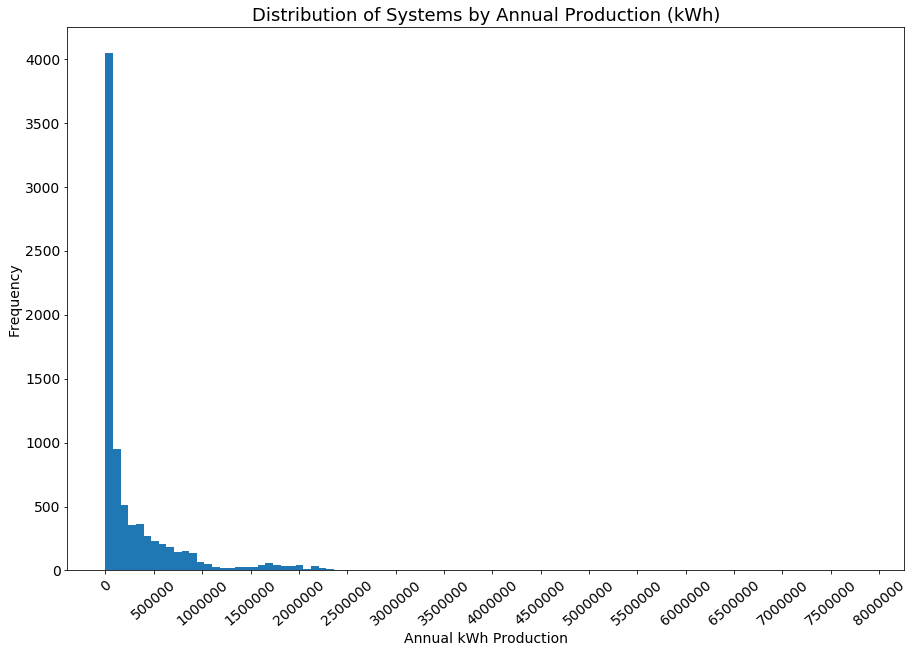

In [56]:
hist_x = df['actualkwh'].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency',fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,8000000,17), fontsize='14', rotation='40')
plt.title('Distribution of Systems by Annual Production (kWh)', fontsize='18')
plt.hist(hist_x, bins=100);

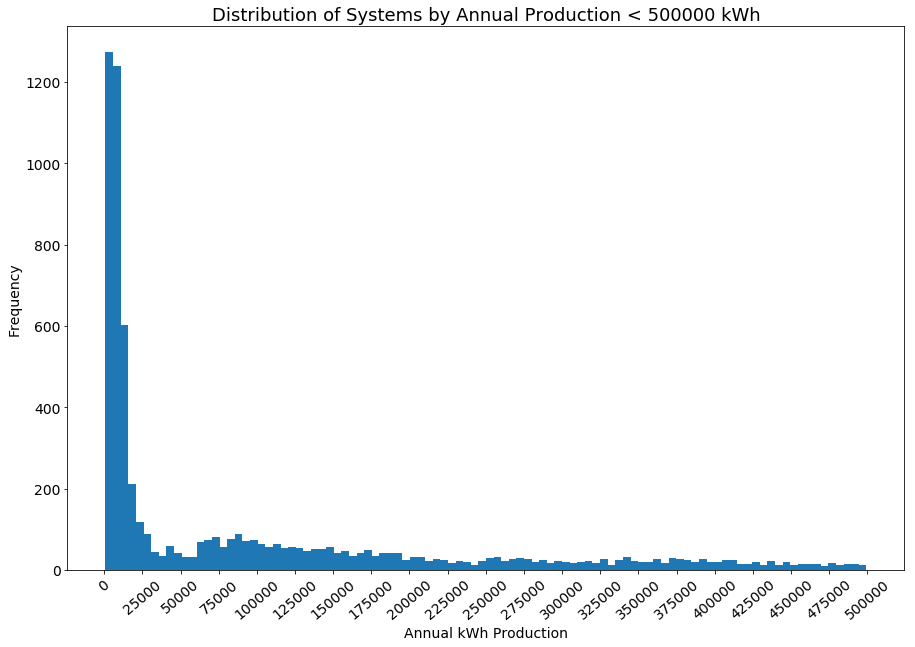

In [55]:
hist_x = df['actualkwh'][df['actualkwh']<500000].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.xticks(np.linspace(0,500000,21), fontsize='14', rotation='40')
plt.yticks(fontsize='14')
plt.title('Distribution of Systems by Annual Production < 500000 kWh', fontsize='18')
plt.hist(hist_x, bins=100);

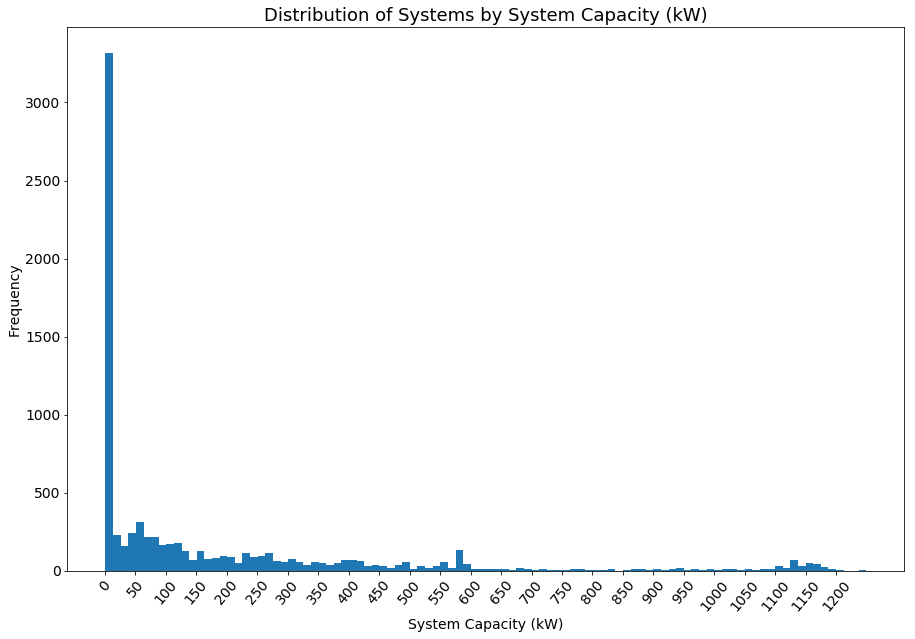

In [69]:
hist_x = df['capacity_dc_kw'][df['capacity_dc_kw']<1300].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('System Capacity (kW)', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,1200,25), fontsize='14', rotation='50')
plt.title('Distribution of Systems by System Capacity (kW)', fontsize='18')
plt.hist(hist_x, bins=100);

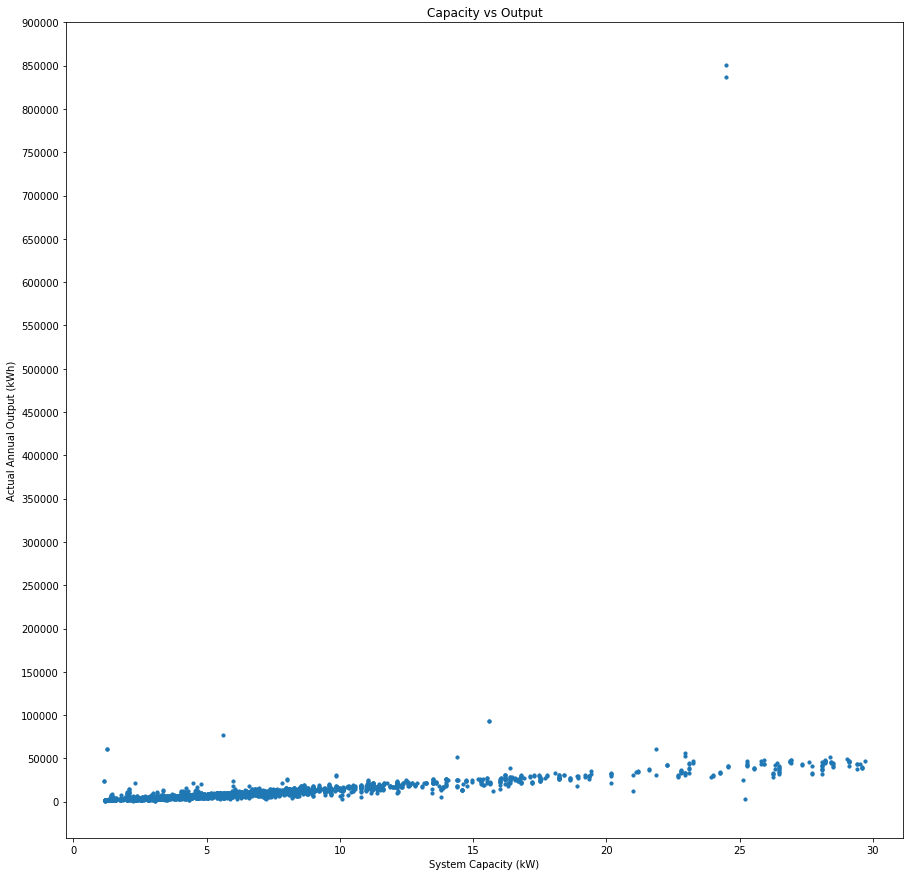

In [88]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'][df['capacity_dc_kw']<30].values, df['actualkwh'][df['capacity_dc_kw']<30].values, s=10)
plt.title("Capacity vs Output")
plt.yticks(np.linspace(0,900000,19))
plt.xlabel("System Capacity (kW)")
plt.ylabel("Actual Annual Output (kWh)");

In [100]:
# pr_std = df.pr.std()
# pr_mean = df.pr.mean()

# pr_mask = np.abs((pr_mean - df['pr'])/pr_std) < 5

# df = df.loc[pr_mask, :]

In [ ]:
df['efficiency'] = df['actualkwh'] / df['capacity_dc_kw']

eff_std = df.efficiency.std()
eff_mean = df.efficiency.mean()

efficiency_mask = np.abs((eff_mean - df['efficiency'])/eff_std) < 5

df = df.loc[efficiency_mask, :]

In [101]:
df.shape

(7961, 14)

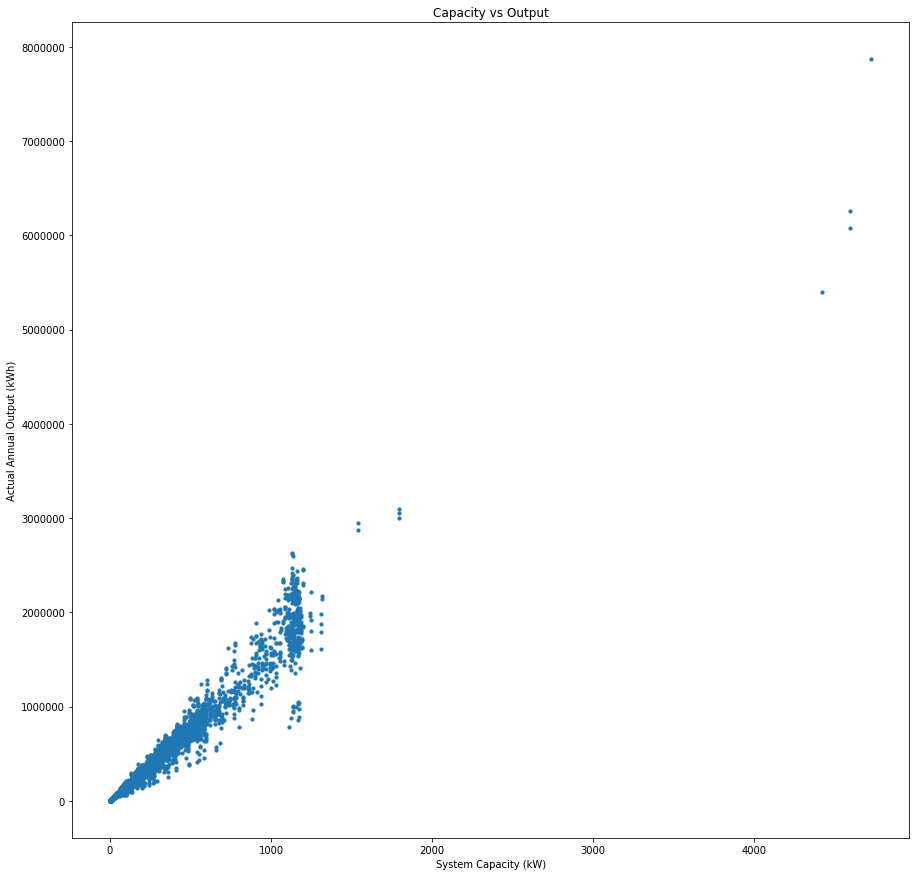

In [102]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'].values, df['actualkwh'].values, s=10)
plt.title("Capacity vs Output")
# plt.yticks(np.linspace(0,900000,19))
plt.xlabel("System Capacity (kW)")
plt.ylabel("Actual Annual Output (kWh)");

In [16]:
df = pd.get_dummies(df,columns = ['mount_type','koeppen','paneltype','cellcategory'], drop_first=True)

In [17]:
df.head().T

,0,1,2,3,4
lat,36.80000,36.800000,34.000000,34.000000,33.80000
actualkwh,215457.08750,193487.660000,288246.650000,252797.225000,56125.00000
irradiancekwh,278138.15643,261959.131597,416118.658276,409327.120794,81674.96556
capacity_dc_kw,161.12000,161.120000,243.200000,243.200000,46.59200
tilt,30.00000,30.000000,30.000000,30.000000,30.00000
azimuth,180.00000,180.000000,180.000000,180.000000,180.00000
year,2009.00000,2010.000000,2009.000000,2010.000000,2009.00000
opt_tilt,6.80000,6.800000,4.000000,4.000000,3.80000
opt_az,0.00000,0.000000,0.000000,0.000000,0.00000
mount_type_Fixed - Roof Mounted,1.00000,1.000000,1.000000,1.000000,1.00000


In [18]:
df.shape

(8157, 16)

In [19]:
df.columns

Index(['lat', 'actualkwh', 'irradiancekwh', 'capacity_dc_kw', 'tilt',
       'azimuth', 'year', 'opt_tilt', 'opt_az',
       'mount_type_Fixed - Roof Mounted', 'koeppen_Moderate',
       'paneltype_other', 'paneltype_poly', 'cellcategory_Premium',
       'cellcategory_Standard', 'cellcategory_Thin Film'],
      dtype='object')

In [41]:
df.describe()

,lat,actualkwh,irradiancekwh,capacity_dc_kw,tilt,azimuth,year,opt_tilt,opt_az,mount_type_Fixed - Roof Mounted,koeppen_Moderate,paneltype_other,paneltype_poly,cellcategory_Premium,cellcategory_Standard,cellcategory_Thin Film
count,8157.000000,8.157000e+03,8.157000e+03,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000
mean,35.863626,2.859747e+05,3.049015e+05,186.823048,18.001018,183.487066,2011.768665,17.914393,16.203997,0.980262,0.958195,0.039843,0.575947,0.384945,0.582935,0.024519
std,2.161258,4.775796e+05,5.143537e+05,299.150419,10.136918,33.426124,1.470674,10.196482,29.442575,0.139106,0.200155,0.195602,0.494229,0.486612,0.493104,0.154663
min,32.600000,7.962080e+02,1.632335e+03,1.150000,0.000000,0.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.800000,8.416804e+03,9.172811e+03,5.775000,10.000000,180.000000,2011.000000,12.600000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.300000,8.187200e+04,8.928459e+04,56.400000,18.000000,180.000000,2012.000000,17.800000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,37.800000,3.716450e+05,4.005345e+05,251.160000,23.000000,184.000000,2013.000000,24.500000,22.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,41.800000,7.867719e+06,9.247761e+06,4725.840000,72.000000,270.000000,2014.000000,41.800000,180.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
cols = ['actualkwh','capacity_dc_kw','opt_norm_tilt','opt_norm_az', 
       'mount_type_Fixed - Roof Mounted', 'koeppen_Moderate', 'paneltype_other', 'paneltype_poly',
        'cellcategory_Premium', 'cellcategory_Standard',
       'cellcategory_Thin Film']
cols2 = ['actualkwh','capacity_dc_kw','opt_tilt', 'opt_az', 
       'mount_type_Fixed - Roof Mounted', 'koeppen_Moderate', 'paneltype_other', 'paneltype_poly']
df_new = df.reindex(cols, axis=1)
df_new2 = df.reindex(cols2, axis=1)

In [21]:
df_new.to_csv('data/df_kg_v1',index=False)

In [33]:
df_new2.to_csv('data/df_kg_v2',index=False)

In [34]:
df_new2.describe()

,actualkwh,capacity_dc_kw,opt_tilt,opt_az,mount_type_Fixed - Roof Mounted,koeppen_Moderate,paneltype_other,paneltype_poly
count,8.157000e+03,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000,8157.000000
mean,2.859747e+05,186.823048,17.914393,16.203997,0.980262,0.958195,0.039843,0.575947
std,4.775796e+05,299.150419,10.196482,29.442575,0.139106,0.200155,0.195602,0.494229
min,7.962080e+02,1.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.416804e+03,5.775000,12.600000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,8.187200e+04,56.400000,17.800000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,3.716450e+05,251.160000,24.500000,22.000000,1.000000,1.000000,0.000000,1.000000
max,7.867719e+06,4725.840000,41.800000,180.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df_new2.corr()

,actualkwh,capacity_dc_kw,opt_tilt,opt_az,mount_type_Fixed - Roof Mounted,koeppen_Moderate,paneltype_other,paneltype_poly
actualkwh,1.000000,0.973386,0.208340,-0.152814,-0.440910,0.067582,-0.000155,0.074306
capacity_dc_kw,0.973386,1.000000,0.202402,-0.151988,-0.367960,0.071578,0.010322,0.073743
opt_tilt,0.208340,0.202402,1.000000,0.096749,-0.254520,0.012148,0.027751,-0.033260
opt_az,-0.152814,-0.151988,0.096749,1.000000,0.071035,0.034861,-0.021211,0.003991
mount_type_Fixed - Roof Mounted,-0.440910,-0.367960,-0.254520,0.071035,1.000000,-0.007621,0.001869,0.004864
koeppen_Moderate,0.067582,0.071578,0.012148,0.034861,-0.007621,1.000000,0.042549,0.160382
paneltype_other,-0.000155,0.010322,0.027751,-0.021211,0.001869,0.042549,1.000000,-0.237403
paneltype_poly,0.074306,0.073743,-0.033260,0.003991,0.004864,0.160382,-0.237403,1.000000


In [71]:
y = df_new.pop('actualkwh')

X = df_new.pop('capacity_dc_kw')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, test_size=.25, random_state=42)

linreg = LinearRegression()
linreg.fit(np.array(X_train).reshape(len(X_train),1), y_train)
linreg.score(np.array(X_test).reshape(len(X_test),1), y_test)

0.9374570485784582

### Dealing with extreme PR values

In [141]:
####  df.sort_values(by =['pr'], ascending=False)